In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_excel('data/Report_21_050718_3.xls')

In [3]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [4]:
df_detailed_demographics = pd.read_excel('data/demographics_detailed.xlsx')

In [5]:
df_detailed_demographics

,ID,GROUP,SEX,AGE,SUICIDE,MODE OF DEATH,TOXICOLOGY,PMI,BRAIN PH,GAS,Duration MDD,MDD Onset,MDD Epi,ETHNICITY,SMOKER
0,1043,Control,F,14,NonSuicide,Traffic Accident-Pedestrian (Accident),NONE,17.0,Pending,100,NaN,NaN,NaN,Caucasian,Light Smoker
1,428,Control,M,19,NonSuicide,Cardiovascular (Natural),NONE,13.0,6.84,90,NaN,NaN,NaN,African-American,Nonsmoker
2,178,Control,M,25,NonSuicide,Stabbing (Accident),NONE,9.5,6.87,76,NaN,NaN,NaN,Caucasian,Nonsmoker
3,771,Control,M,31,NonSuicide,Traffic Accident-Driver (Accident),NONE,10.0,6.24,82,NaN,NaN,NaN,Caucasian,Moderate Smoker
4,398,Control,M,37,NonSuicide,Cardiovascular (Natural),NONE,15.0,6.75,60,NaN,NaN,NaN,African-American,Nonsmoker
5,342,Control,M,39,NonSuicide,Cardiovascular (Natural),NONE,14.0,6.79,90,NaN,NaN,NaN,Caucasian,Nonsmoker
6,892,Control,F,50,NonSuicide,Peritonitis (Natural),NONE,22.0,6.1,70,NaN,NaN,NaN,Caucasian,Moderate Smoker
7,542,Control,M,53,NonSuicide,Stabbing (Homicide),NONE,16.0,6.24,80,NaN,NaN,NaN,Caucasian,Moderate Smoker
8,766,Control,F,56,NonSuicide,Traffic Accident-Pedestrian (Accident),NONE,19.0,6.08,86,NaN,NaN,NaN,Caucasian,Nonsmoker
9,432,Control,M,58,NonSuicide,Cardiovascular (Natural),NONE,22.0,6.44,85,NaN,NaN,NaN,Caucasian,Nonsmoker


In [6]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [5]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)
out = out.replace(np.nan,0)

##### Fix Types

In [6]:
out['dose'] = out['dose'].astype('int64', copy=False)

In [7]:
out = out.replace(0,np.nan)

In [8]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

In [9]:
numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = np.log(numeric_cols)
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

In [10]:
data = out

In [11]:
data = data.drop(['group','gr','sex'], axis=1)

In [12]:
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)
data_y = data['suicide']
data_x = data.drop(['suicide','dt_start','dt_end'], axis = 1)

# Use random forest to identify important features

In [17]:
import warnings
from xgboost import XGBClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    xgb = XGBClassifier(n_estimators=100,max_depth = 5 , class_weight="balanced", random_state=100)
    xgb.fit(data_x,data_y)

In [18]:
importances = xgb.feature_importances_

In [19]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

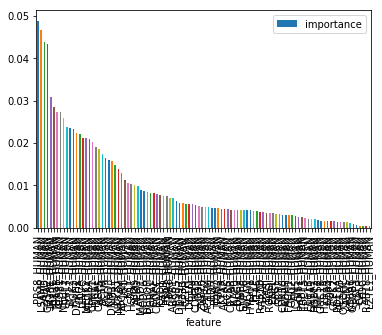

In [20]:
feature_rank[feature_rank['importance']>0].plot.bar(x='feature', y='importance', rot=90)

# Visualize the distribution of the most important feature identified by Random Forest

In [ ]:
nonsuicide depressed, suicdie depressed, controls 

PRS8_HUMAN


C:\Users\James\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


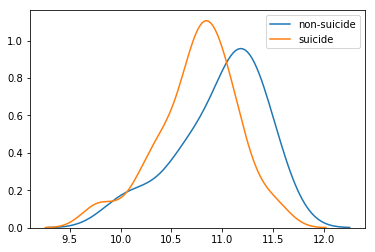

In [19]:
feature1 = feature_rank.iloc[0]['feature']
print(feature1)
sns.kdeplot(data[(data['suicide']==0)]['FGF9_HUMAN'],label='non-suicide')
sns.kdeplot(data[(data['suicide']==1)]['FGF9_HUMAN'],label='suicide')

# Run t-test to see which features are statistically significant between two groups

In [20]:
import scipy 

In [21]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)[1]
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

In [22]:
scipy.stats.mannwhitneyu(data[data['suicide']==0][feature], data[data['suicide']==1][feature], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=431.0, pvalue=0.007770977240719859)

### Using Boneferroni adjustments

In [23]:
pvalues[pvalues['pvalues']<0.05/100]

,feature,pvalues
0,PRS8_HUMAN,0.000273
16,ATD3A_HUMAN,0.000067
17,CPNE1_HUMAN,0.000380


### Using Benjamini–Hochberg procedure, with 5% false positive rate

In [24]:
pvalues['rank'] = np.argsort(pvalues.pvalues).argsort()+1

In [25]:
pvalues[pvalues['pvalues'] < pvalues['rank']/100*.05]

,feature,pvalues,rank
0,PRS8_HUMAN,0.000273,2
6,TBA4B_HUMAN,0.003570,11
11,PGK2_HUMAN,0.002714,10
16,ATD3A_HUMAN,0.000067,1
17,CPNE1_HUMAN,0.000380,3
22,KAD3_HUMAN,0.000841,5
30,SBDS_HUMAN,0.001373,7
49,CDK13_HUMAN,0.001976,8
51,ZNF76_HUMAN,0.000980,6
73,ENPL_HUMAN,0.000640,4


### Effect Size Comparisons between Depressed vs Suicide and Nondepressed vs Suicide

### Depressed vs Suicide

In [26]:
data = out
data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)

In [27]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [28]:
cohen_dvs = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']=='c'][feature], data[data['suicide']==1][feature])
        cohen_dvs.append([feature,res])

cohen_dvs = pd.DataFrame(cohen_dvs)
cohen_dvs = cohen_dvs.rename(columns={0:'feature',1:'cohend'})

In [29]:
cohen_dvns = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']!='c'][feature], data[data['suicide']==1][feature])
        cohen_dvns.append([feature,res])

cohen_dvns = pd.DataFrame(cohen_dvns)
cohen_dvns = cohen_dvns.rename(columns={0:'feature',1:'cohend'})

### Largest Differences by Cohen's D

In [33]:
cohen_dvns['feature'][np.argsort(-(np.abs(cohen_dvs['cohend'] - cohen_dvns['cohend'])))][0:5]

49    CDK13_HUMAN
36     GNAL_HUMAN
63    CPNE8_HUMAN
16    ATD3A_HUMAN
0      PRS8_HUMAN
Name: feature, dtype: object

### Control vs Depressed

In [39]:
cohen_dvs = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']=='c'][feature], data[data['group']=='m'][feature])
        cohen_dvs.append([feature,res])

cohen_dvs = pd.DataFrame(cohen_dvs)
cohen_dvs = cohen_dvs.rename(columns={0:'feature',1:'cohend'})

In [38]:
cohen_dvns = []
data = out 
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        res = cohend(data[data['group']!='c'][feature], data[data['group']=='a'][feature])
        cohen_dvns.append([feature,res])

cohen_dvns = pd.DataFrame(cohen_dvns)
cohen_dvns = cohen_dvns.rename(columns={0:'feature',1:'cohend'})

Go through the overlaps in these 

In [40]:
cohen_dvns['feature'][np.argsort(-(np.abs(cohen_dvs['cohend'] - cohen_dvns['cohend'])))][0:5]

63    CPNE8_HUMAN
68     ITA6_HUMAN
34    DBLOH_HUMAN
49    CDK13_HUMAN
36     GNAL_HUMAN
Name: feature, dtype: object

### Summary
Log adjustment to data
fill 0s by group, sex
nonparametric test - mann whiteney u. Can only be used for ordinal data(larger is significant) For each observation in one set, count the number of times this first value wins over any observation.
Boneferroni correction since we are making lots of tests. Picked 100 most important features.
4 were significant
ATD3A_HUMAN	0.000067
CPNE1_HUMAN	0.000380
PRS8_HUMAN	0.000273
SYFA_HUMAN	0.000084

### Demographics

In [33]:
data = pd.read_csv('data/final.csv')

In [ ]:
data = data.drop('Unnamed: 0', axis =1)

In [46]:
demo_df = pd.read_excel('data/demographics_cell_numbers.xlsx')

In [49]:
demo_df = demo_df[['ID','ETHNICITY','SMOKER']]

In [51]:
demo_df.columns = ['patient_id','ethnicity','smoker']

In [64]:
data = data.merge(demo_df,on ='patient_id')

In [66]:
import scipy 

In [71]:
data.columns

Index(['patient_id', '1433B_HUMAN', '1433E_HUMAN', '1433F_HUMAN',
       '1433G_HUMAN', '1433S_HUMAN', '1433T_HUMAN', '1433Z_HUMAN',
       '2AAA_HUMAN', '2ABA_HUMAN',
       ...
       'ZN346_HUMAN', 'ZNF76_HUMAN', 'dose', 'group', 'age', 'sex', 'gr',
       'suicide', 'ethnicity', 'smoker'],
      dtype='object', length=1140)

In [86]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[data['ethnicity']=='Caucasian'][feature], data[data['ethnicity']!='Caucasian'][feature], use_continuity=True, alternative=None)[1]
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

In [81]:
data.smoker.unique()

array(['Nonsmoker', 'Pending', 'Moderate Smoker', 'Light Smoker'],
      dtype=object)

In [83]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    if index > 100:
        break
    feature = row['feature']
    if feature != 'dt_end':
        p = scipy.stats.mannwhitneyu(data[(data['smoker']=='Nonsmoker')&(data['smoker']!='Pending')][feature], data[(data['smoker']!='Nonsmoker')&(data['smoker']!='Pending')][feature], use_continuity=True, alternative=None)[1]
        pvalues.append([feature,p])

pvalues_cig = pd.DataFrame(pvalues)
pvalues_cig = pvalues_cig.rename(columns={0:'feature',1:'pvalues'})

### Using Boneferroni adjustments

no significance for caucasian vs non-caucasian and cig vs noncig

In [78]:
pvalues[pvalues['pvalues']<0.05/100]

,feature,pvalues


In [84]:
pvalues_cig[pvalues_cig['pvalues']<0.05/100]

,feature,pvalues


Union of importances suicide vs non, treated vs nontreated

### Using Benjamini–Hochberg procedure, with 5% false positive rate

In [87]:
pvalues['rank'] = np.argsort(pvalues.pvalues).argsort()+1

In [88]:
pvalues[pvalues['pvalues'] < pvalues['rank']/100*.05]

,feature,pvalues,rank


In [89]:
pvalues_cig['rank'] = np.argsort(pvalues.pvalues).argsort()+1

In [90]:
pvalues_cig[pvalues_cig['pvalues'] < pvalues_cig['rank']/100*.05]

,feature,pvalues,rank


### Cell Counts

In [7]:
demo_df = pd.read_excel('data/demographics_cell_numbers.xlsx')

In [8]:
cell_cols_features = list(demo_df.columns[17:])

In [9]:
cell_cols =  cell_cols_features+(['ID','SUICIDE'])

In [10]:
data = demo_df[cell_cols]

In [12]:
from scipy import stats
import scipy

pvalues = []
for feature in cell_cols_features:
    p = scipy.stats.mannwhitneyu(data[(data['SUICIDE']=='Suicide')][feature], data[(data['SUICIDE']!='Suicide')][feature], use_continuity=True, alternative=None)[1]
    pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

In [13]:
pvalues[pvalues['pvalues']<0.05/13]

,feature,pvalues


In [14]:
pvalues['rank'] = np.argsort(pvalues.pvalues).argsort()+1

In [15]:
pvalues[pvalues['pvalues'] < pvalues['rank']/13*.05]

,feature,pvalues,rank


In [16]:
from scipy import stats
import scipy

pvalues = []
for feature in cell_cols_features:
    p = scipy.stats.mannwhitneyu(data[data['ethnicity']=='Caucasian'][feature], data[data['ethnicity']!='Caucasian'][feature], use_continuity=True, alternative=None)[1]
    pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})

KeyError: 'ethnicity'